In [196]:
import pandas as pd

## Data Cleaning `application.csv'

Removing unwanted columns: mobile, work_phone, phone, email

In [197]:
# loading data
df_a = pd.read_csv("application.csv").iloc[:,1:]

# Dropping unwanted columns
df_a.drop(columns = ["mobile", "work_phone", "phone", "email"], inplace = True)

# Replacing Y and N with 1 and 0 respectively
df_a.replace(to_replace = ("Y", "N"),
             value = (1, 0), inplace = True)

# Removing multiple applications and keeping the latest one
df_a = df_a.sort_values("birth_day").drop_duplicates("id")

## Data Cleaning 'credit_record.csv'

Status: "X", "C" as Approve credit (assign as 1) "0", "1", "2", "3", "4", "5" as Deny credit (assign as 0)

Find the mean credit status of each client

In [198]:
# loading data
df_cr = pd.read_csv("credit_record.csv").iloc[:,1:]

# Replacing the status with 0 as deny and 1 as approve
df_cr.replace(to_replace = ("X", "C", "0", "1", "2", "3", "4", "5"),
              value = (1, 1, 0, 0, 0, 0, 0, 0), inplace = True)

# Finding the mean status given the multiple records of each client
df_cr = df_cr.groupby("id")["status"].mean().round().reset_index()

## Data Processing

Merging both data frames using inner join on the credit record data frame

Drop id column and remove rows with missing values in the job column

In [202]:
# Merging both data frames using inner join
df = df_cr.join(df_a.set_index("id"), on = "id", how = 'inner')

# Dropping id column and remove missing values
df.drop(columns = "id", inplace = True)
df.dropna(axis = 0, inplace = True)

# Converting categorical features to dummy variables
gender = pd.get_dummies(df["gender"])
income_type = pd.get_dummies(df["income_type"])
education_level = pd.get_dummies(df["education_level"])
family_status = pd.get_dummies(df["family_status"])
house_type = pd.get_dummies(df["house_type"])
job = pd.get_dummies(df["job"])

# Dropping columns being replaced with dummies
df.drop(columns = ["gender", "income_type", "education_level",
                   "family_status", "house_type", "job"],
        inplace = True)

# Merge new columns with dummy variables to df
df = pd.concat([df, gender, income_type, education_level, family_status,
                house_type, job], axis = 1)

# Getting labels
yvals = pd.DataFrame(df["status"])
xvals = df.drop(columns = "status")

# Splitting the dataset into training data and test data
# using train-and-test split method
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xvals, yvals, test_size = 0.25,
                                                random_state = 0)

# Standardizing the training and test data
from sklearn.preprocessing import StandardScaler
std_x = StandardScaler()
xtrain = std_x.fit_transform(xtrain)
xtest = std_x.fit_transform(xtest)

## Logistic Regression

In [203]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Fitting the model
classifier.fit(xtrain, ytrain)

# Output prediction for xtest data
ypred = classifier.predict(xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model Evaluation

In [204]:
# Model Evaluation
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.52      0.25      0.34      3021
         1.0       0.53      0.79      0.63      3263

    accuracy                           0.53      6284
   macro avg       0.53      0.52      0.49      6284
weighted avg       0.53      0.53      0.49      6284



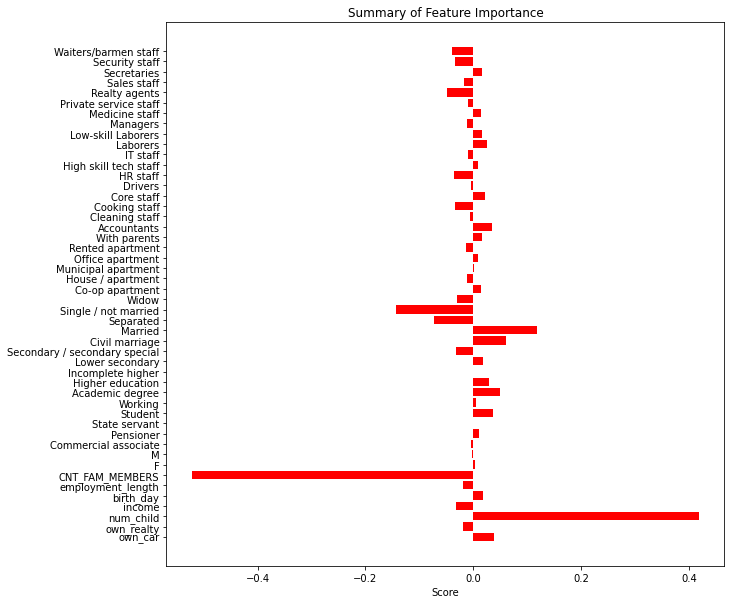

In [205]:
# Feature Importance
import matplotlib.pyplot as plt

importance = classifier.coef_.flatten()

plt.rcParams["figure.figsize"] = (10, 10)
plt.barh(xvals.columns, importance, color = 'r')
plt.title("Summary of Feature Importance")
plt.xlabel("Score")
plt.show()